In [1]:
import dolfin as dl
import numpy as np
import pandas as pd

# from datetime import datetime
import datetime

import os
import sys
import copy

import argparse
import timeit

In [2]:
import pyvista as pv
import geopandas as gpd
from shapely.geometry import Point
from descartes import PolygonPatch

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set_style("white")
sns.set_style("ticks")

# Load district data

In particular, we are interested in  polygons for each each district. This polygon will be used to find if the point in the element is inside particular district.

In [4]:
county_process_path = '../county_data/'
dist_process_path = './'
sys.path.insert(0, county_process_path)

from read_district_data import *
from read_county_data import *

In [5]:
# get county data
county_nms, county_dist, county_dist_names, county_polys = read_county_map(county_process_path + '/data/')

In [6]:
# get district data
new_dist_nm, new_dist_county_nbr, new_dist_county_nm, new_dist_geom = read_dist_map(dist_process_path + '/data/', 
                                                county_nms, county_dist, 
                                                  county_dist_names, county_polys, 0)

# Subdomain class

In [7]:
class DistrictSubDomain(dl.SubDomain):
    
    def set(self, district, dist_geom):
        self.district = district
        self.dist_geom = dist_geom
    
    def inside(self, x, on_boundary):
        
        dist = []
        return self.dist_geom[self.district].contains(Point(x[0],x[1]))

# Load mesh and mark elements based on the district

In [10]:
mesh_fname = 'mesh_4h'
mesh = dl.Mesh('../../Data/mesh/' + mesh_fname + ".xml")

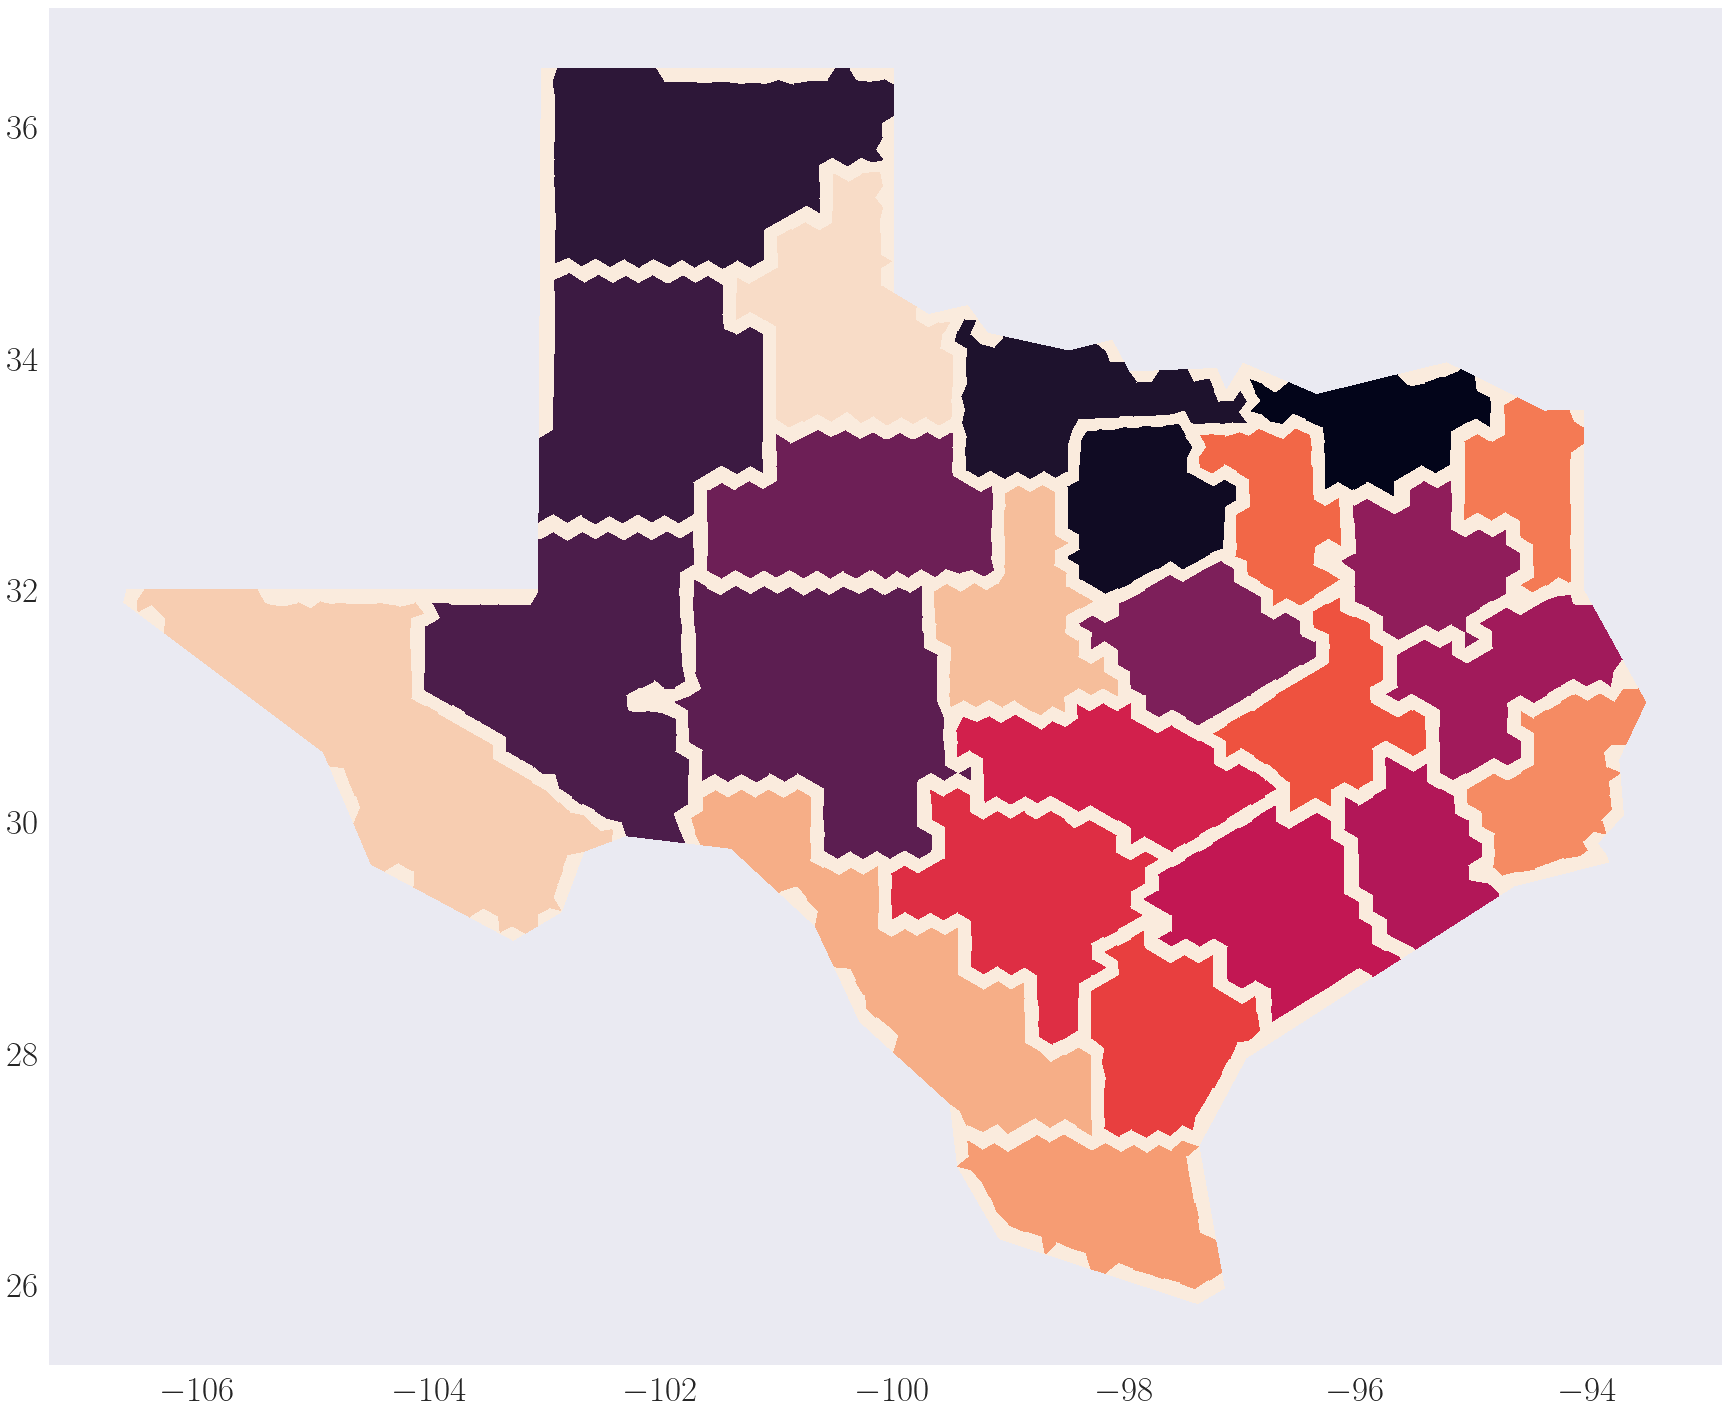

In [11]:
subdomain = dl.MeshFunction("size_t", mesh, 2)
# tag total domain as 25
subdomain.set_all(25)

dist_subdmns = [DistrictSubDomain() for i in range(25)]
for i in range(25):
    dist_subdmns[i].set(district=i, dist_geom = new_dist_geom)
    dist_subdmns[i].mark(subdomain, i)

fig = plt.figure(figsize=(30, 30))
plt.autoscale(enable=True, axis='both')
dl.plot(subdomain)

# Save to file

In [12]:
# save to file
dl.File('data/subdomains/subdomain_' + mesh_fname + '.xml.gz') << subdomain

# Load subdomain file

In [14]:
# read from file
subdomain_rd = dl.MeshFunction("size_t", mesh, 2)
dl.File('data/subdomains/subdomain_' + mesh_fname + '.xml.gz') >> subdomain_rd

# Create a measure restricted on given subdomain

This measure can then be used to compute QoI restricted on given subdomain.

In [16]:
# dx_dist = [dl.Measure('dx', domain=mesh, subdomain_data=indicator_fns_test_2[i]) for i in range(25)]
dx_dist = dl.Measure('dx', domain=mesh, subdomain_data=subdomain_rd)
dx = dl.Measure('dx', domain=mesh)

# Check area of subdomain and compare with area of district 

Since subdomain of a district consists of elements which are completely inside, the area of district subdomain will be little less than the area of district.

In [17]:
area_dist_cal = [0. for i in range(25)]
area_dist_act = [0. for i in range(25)]
factor_dist_area = [1. for i in range(25)]
for i in range(25):
    area_dist_cal[i] = dl.assemble(dl.Constant(1.0)*dl.Constant(1.0)*dx_dist(i))
    area_dist_act[i] = new_dist_geom[i].area
    factor_dist_area[i] = area_dist_act[i] / area_dist_cal[i]
    print('district: {0:<5} actual area: {1:<5} computed area: {2:<5} factor: {3}'.format(i, 
                        area_dist_act[i], area_dist_cal[i], factor_dist_area[i]))
    
print('actual total area: {0:<5} sum dist area: {1:<5} comp total are: {2}'.format(
    np.sum(area_dist_act), np.sum(area_dist_cal), dl.assemble(dl.Constant(1.0)*dl.Constant(1.0)*dx)))

# np.save('data/subdomains/area_factor_' + mesh_fname + '.npy', factor_dist_area)

Calling FFC just-in-time (JIT) compiler, this may take some time.
district: 0     actual area: 1.6014532991460728 computed area: 1.2130899501854029 factor: 1.3201439010366167
Calling FFC just-in-time (JIT) compiler, this may take some time.
district: 1     actual area: 1.7669818681646594 computed area: 1.488485123713298 factor: 1.187100791277376
Calling FFC just-in-time (JIT) compiler, this may take some time.
district: 2     actual area: 2.0662926054099713 computed area: 1.6463481564294193 factor: 1.2550763320264666
Calling FFC just-in-time (JIT) compiler, this may take some time.
district: 3     actual area: 4.620645546913652 computed area: 3.8955902209106332 factor: 1.1861220726222919
Calling FFC just-in-time (JIT) compiler, this may take some time.
district: 4     actual area: 4.003143226849417 computed area: 3.4371426374213665 factor: 1.1646718362123833
Calling FFC just-in-time (JIT) compiler, this may take some time.
district: 5     actual area: 4.50638253516794 computed area: 3.